In [9]:
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
import pandas as pd
import time
from datetime import datetime
import nltk
import selenium

In [10]:
HOME = "https://www.youtube.com/user/theneedledrop/videos"

In [11]:
def get_score(url):
    """
    get_score obtains the score and date of an Anthony Fantano review
    
    url - Str
    
    returns int
    """
    result = requests.get(url)
    c = result.content

    soup = BeautifulSoup(c)

    date = soup.find("strong", {"class": "watch-time-text"})
    if date == None:
        date = soup.find("strong", {"class": "date style-scope ytd-video-secondary-info-renderer"})
    date = date.text
    date = datetime.strptime(date, 'Published on %b %d, %Y')
    
    child = str(soup.find("div", {"id": "watch-description-text"}))
    
    #tknizer = nltk.tokenize.ToktokTokenizer()

    #tokenized = tknizer.tokenize(child)
    tokenized = nltk.tokenize.casual_tokenize(child)

    str_score = ''
    
    for i, token in enumerate(tokenized):
        if "/10" == token:
            str_score = tokenized[i-1]
            ind = i
            break
        elif ("10" == token and '/' == tokenized[i-1]):
            str_score = tokenized[i-2]
            break
        elif ("10" == token and '/' in tokenized[i-1]):
            str_score = tokenized[i-1].split("/")[0]
            break
        elif "/10" in str(token) and len(token) < 10:
            str_score = tokenized[i].split("/")[0]
            ind = i
            break

    if str_score == '':
        score = None
    else:        
        if str_score.isdigit():
            score = int(str_score)
        else:
            score = str_score
    
    appending_fave = False
    appending_lfave = False
    fave_tracks = []
    lfave_track = []

    for i, token in enumerate(tokenized):
        if appending_fave:
            if token == '<br/>' or token == '</p>':
                appending_fave = False
            else:
                fave_tracks.append(token)
                
        if appending_lfave:
            if token == '<br/>' or token == '</p>':
                appending_lfave = False
                break
            else:
                lfave_track.append(token)
        
        if tokenized[i-1] == "TRACKS" and token == ":":
            appending_fave = True
        
        if tokenized[i-1] == "TRACK":
            appending_lfave = True
    
    
    if fave_tracks != []: 
        fave_tracks = ' '.join(fave_tracks)
        fave_tracks = fave_tracks.split(", ")
    else:
        fave_tracks = []
    if lfave_track != []:
        lfave_track = ' '.join(lfave_track)
    else:
        lfave_track = ''
    return score, date, fave_tracks, lfave_track

In [12]:
def scroll():
    """
    scrolls to the bottom of the page
    
    code taken from https://stackoverflow.com/questions/20986631/how-can-i-scroll-a-web-page-using-selenium-webdriver-in-python
    modified slightly for YouTube
    """
    
    SCROLL_PAUSE_TIME = 0.5
    
    last_height = driver.execute_script("return window.scrollY")    
    
    tries = 0
    while True:
        down_height = last_height + 1000
        driver.execute_script("window.scrollTo(0," + str(down_height)  + ")")
        
        time.sleep(SCROLL_PAUSE_TIME)
        
        new_height = driver.execute_script("return window.scrollY")
        if new_height == last_height:
            tries += 1
            time.sleep(SCROLL_PAUSE_TIME)
            if tries == 50:
                break
        else:
            tries = 0
        last_height = new_height

In [13]:
def scroll_update(latest_review_url):
    """
    scrolls to the point where the dataset was last updated
    
    code taken from https://stackoverflow.com/questions/20986631/how-can-i-scroll-a-web-page-using-selenium-webdriver-in-python
    modified slightly for YouTube
    """
    
    SCROLL_PAUSE_TIME = 0.5
    
    last_height = driver.execute_script("return window.scrollY")    
    tries = 0
    while True:
        down_height = last_height + 1000
        driver.execute_script("window.scrollTo(0," + str(down_height)  + ")")
        
        time.sleep(SCROLL_PAUSE_TIME)
        
        new_height = driver.execute_script("return window.scrollY")
        if new_height == last_height:
            tries += 1
            if tries == 10:
                break
        elif latest_review_url in driver.page_source:
            break
        else:
            tries = 0
        last_height = new_height

In [14]:
def get_title_artist(title_element):
    """
    get_title_artist takes a title element and extracts the artist of the album an
    the title of the album
    """    
    
    
    title_token = title_element.text.split(" ")


    word = title_token.pop(0)
    artist = ''
    title = ''
    first = True
    while(title_token != [] and word != '-' and word[-1] != '-'):
        if first:
            first = False
            artist += (word)
        else:
            artist += ' '
            artist += word

        word = title_token.pop(0)
    
    if word[-1] == '-' and len(word) > 1:
        word = word[:-1]
        artist += ' '
        artist += word
        
    if title_token == []:
        print("ERROR HERE: ", title_element.text)
        return None, None
    
    word = title_token.pop(0)
    first = True

    while(True):
        if first:
            first = False
            title += word
        else:
            title += ' '
            title += word
        if title_token != []:
            word = title_token.pop(0)
            if word == "ALBUM" or (word == "EP" and title_token[0] == "REVIEW"):
                break
        else:
            break
    return title, artist

In [15]:
def get_captions(link, driver):
    """ Gets the youtube auto-generated captions to a link
    """
    caption_link = 'http://www.diycaptions.com/php/start.php?id='
    
    key = link.split("=")[1]
    driver.get(caption_link + key)
    caption = ''
    i = 0
    time.sleep(4)
    while(True):
        i += 1
        try:
            text = driver.find_element_by_id(str(i)).text
        except selenium.common.exceptions.NoSuchElementException:
            return caption
        caption += text + ' '  
    all_captions.append({'url': link, 'caption': caption})

## fantano_reviews scrapers

In [16]:
#run to scrape fantano_reviews.csv from beginning

driver = webdriver.Chrome()

driver.get(HOME)

scroll()

element_titles = driver.find_elements_by_id("video-title")

#regular scraper
list_of_rows = []
i = 0
for e in element_titles:
    title = e.text
    if "ALBUM REVIEW" in title:
        review_type = "Album"
    elif "EP REVIEW" in title:
        review_type = "EP"
    else:
        continue
        
    i += 1
    link = e.get_attribute("href")
    score, review_date, best_tracks, worst_track = get_score(link)
    
    if isinstance(score, str):
        word_score = score
        score = None
    else:
        word_score = None
    
    title, artist = get_title_artist(e)

    if title == None:
        continue
    
    row_dict = {"title": title, "artist": artist,
                "score": score, "word_score": word_score,
                "link": str(link), "review_type": review_type,
                "review_date": review_date, "best_tracks": best_tracks,
                "worst_track": worst_track}
    if i % 10 == 0:
        print("\n\n", str(i), "th Review\n")
        print("row: ", row_dict)

    list_of_rows.append(row_dict)

df = pd.DataFrame(list_of_rows)
cols = ['title', 'artist', 'review_date', 'review_type', 'score', 'word_score', 'best_tracks', 'worst_track', 'link']
df = df[cols]
df = df.sort_values(by=['review_date'])
df = df.reset_index(drop=True)
df.to_csv("./dataset/fantano_reviews.csv")

C:\Users\Jared\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\Jared\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))




 10 th Review

row:  {'title': 'Godfather II', 'artist': 'Wiley', 'score': 5, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=1K6l7wIuOHg', 'review_type': 'Album', 'review_date': datetime.datetime(2018, 5, 10, 0, 0), 'best_tracks': ['BEEN A WHILE ', 'I CALL THE SHOTS ', 'BAR'], 'worst_track': 'ALL THE TIME'}


 20 th Review

row:  {'title': 'Eat the Elephant', 'artist': 'A Perfect Circle', 'score': 5, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=ZruuCzKf70k', 'review_type': 'Album', 'review_date': datetime.datetime(2018, 4, 26, 0, 0), 'best_tracks': ['DISILLUSIONED ', 'THE CONTRARIAN ', 'THE DOOMED ', 'SO LONG AND THANKS FOR ALL THE FISH'], 'worst_track': 'HOURGLASS'}


 30 th Review

row:  {'title': 'Golden Hour', 'artist': 'Kacey Musgraves', 'score': 4, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=m8PBrunDIfI', 'review_type': 'Album', 'review_date': datetime.datetime(2018, 4, 7, 0, 0), 'best_tracks': ['LOVE IS A WILD THING ', 'RAINBOW ',



 240 th Review

row:  {'title': '9', 'artist': 'Cashmere Cat', 'score': None, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=jeHGfiHDwxc', 'review_type': 'Album', 'review_date': datetime.datetime(2017, 5, 4, 0, 0), 'best_tracks': [], 'worst_track': ''}


 250 th Review

row:  {'title': 'Self-Titled', 'artist': 'Arca', 'score': 5, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=IZxa8FaUYOw', 'review_type': 'Album', 'review_date': datetime.datetime(2017, 4, 13, 0, 0), 'best_tracks': ['SIN RUMBO ', 'ANOCHE ', 'CASTRATION'], 'worst_track': 'URCHIN'}


 260 th Review

row:  {'title': 'Baile Bucanero', 'artist': 'Ondatrópica', 'score': 7, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=1GRf65B6-Qw', 'review_type': 'Album', 'review_date': datetime.datetime(2017, 3, 30, 0, 0), 'best_tracks': ['MALARIA ', 'DE MAR A MAR ', 'HUMMINGBIRD ', 'CAMPESINO ', 'BOGA CANOERO'], 'worst_track': 'ESTAR CONTIGO'}


 270 th Review

row:  {'title': 'Brutalism', 'artist



 460 th Review

row:  {'title': 'One Day You Will Ache Like I Ache', 'artist': 'The Body and Full of Hell', 'score': 7, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=cGmrG1JAYaQ', 'review_type': 'Album', 'review_date': datetime.datetime(2016, 3, 23, 0, 0), 'best_tracks': ['ONE DAY YOU WILL ACHE LIKE I ACHE ', 'HIMMEL AND HOLLE ', 'BOTTLED URN ', 'THE LITTLE DEATH'], 'worst_track': 'THE BUTCHER ( LEONARD COHEN COVER )'}


 470 th Review

row:  {'title': 'The Terrible Tales of Scurvy Jones', 'artist': 'Mr. Yote', 'score': 7, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=J3dF8yhnsu0', 'review_type': 'EP', 'review_date': datetime.datetime(2016, 3, 9, 0, 0), 'best_tracks': ['BAIT ', 'SS MUD ', 'BOILING BAYOU'], 'worst_track': 'BLUE BEARD'}


 480 th Review

row:  {'title': 'Pool', 'artist': 'Porches', 'score': 5, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=zVlcqnrWUT8', 'review_type': 'Album', 'review_date': datetime.datetime(2016, 2, 17, 0, 



 690 th Review

row:  {'title': 'The Powers That B (Niggas On the Moon / Jenny Death)', 'artist': 'Death Grips', 'score': 9, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=yKyWZeiRe8c', 'review_type': 'Album', 'review_date': datetime.datetime(2015, 3, 23, 0, 0), 'best_tracks': ['UP MY SLEEVES ', 'BILLY NOT REALLY ', 'FUCK ME OUT ', 'VOILA ', 'SAY HEY KID'], 'worst_track': 'BLACK QUARTERBACK'}


 700 th Review

row:  {'title': "You're Better Than This", 'artist': 'Pile', 'score': 6, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=2aX-AqRgjIo', 'review_type': 'Album', 'review_date': datetime.datetime(2015, 3, 5, 0, 0), 'best_tracks': ['MR . FISH ', 'HOT BREATH ', 'FUCK THE POLICE'], 'worst_track': 'TIN FOIL HAT'}


 710 th Review

row:  {'title': 'EarthEE', 'artist': 'THEESatisfaction', 'score': 7, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=NXwhaTEW9Vc', 'review_type': 'Album', 'review_date': datetime.datetime(2015, 2, 20, 0, 0), 'best_track



 920 th Review

row:  {'title': 'Singles', 'artist': 'Future Islands', 'score': 7, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=Zr4YJIqx31c', 'review_type': 'Album', 'review_date': datetime.datetime(2014, 3, 25, 0, 0), 'best_tracks': ['SEASONS ( WAITING ON YOU ) ', 'A DREAM OF YOU AND ME ', 'A SONG FOR OUR GRANDFATHERS ', 'DOVES ', 'SUN IN THE MORNING'], 'worst_track': 'SPIRIT'}


 930 th Review

row:  {'title': 'Morning Phase', 'artist': 'Beck', 'score': 4, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=BrAgo1Qh4uk', 'review_type': 'Album', 'review_date': datetime.datetime(2014, 3, 3, 0, 0), 'best_tracks': ['TURN AWAY'], 'worst_track': 'MORNING'}


 940 th Review

row:  {'title': 'Lord Steppington', 'artist': 'Step Brothers', 'score': 8, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=oZsH0U3tZbA', 'review_type': 'Album', 'review_date': datetime.datetime(2014, 2, 13, 0, 0), 'best_tracks': ['SWIMTEAM RASTAS ', 'MUMS IN THE GARAGE ', 'SEE THE



 1140 th Review

row:  {'title': 'The Raven That Refused To Sing (And Other Stories)', 'artist': 'Steven Wilson', 'score': 5, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=mP7tl9-luZE', 'review_type': 'Album', 'review_date': datetime.datetime(2013, 3, 5, 0, 0), 'best_tracks': ['THE RAVEN THAT REFUSED TO SING'], 'worst_track': 'THE PIN DROP'}


 1150 th Review

row:  {'title': 'Vexovoid', 'artist': 'Portal', 'score': 5, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=Rv3qVx2fUCU', 'review_type': 'Album', 'review_date': datetime.datetime(2013, 2, 19, 0, 0), 'best_tracks': ['THE BACK WARDS ', 'AWRYEON'], 'worst_track': 'OBLOTTEN'}


 1160 th Review

row:  {'title': 'Heartthrob', 'artist': 'Tegan and Sara', 'score': 3, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=S8WH_9n6x9w', 'review_type': 'Album', 'review_date': datetime.datetime(2013, 2, 4, 0, 0), 'best_tracks': [], 'worst_track': 'CLOSER'}


 1170 th Review

row:  {'title': 'We Are the 21s



 1370 th Review

row:  {'title': 'Reign of Terror', 'artist': 'Sleigh Bells', 'score': 5, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=X-VSXW3qthQ', 'review_type': 'Album', 'review_date': datetime.datetime(2012, 2, 22, 0, 0), 'best_tracks': ['ROAD TO HELL ', 'YOU LOST MED'], 'worst_track': 'TRUE SHRED GUITAR'}


 1380 th Review

row:  {'title': 'Vacation', 'artist': ' Shlohmo', 'score': 7, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=8Mxjjefgprw', 'review_type': 'EP', 'review_date': datetime.datetime(2012, 2, 8, 0, 0), 'best_tracks': ['WELL ', 'UH ...'], 'worst_track': "THERE'S ONLY , LIKE , THREE ON HERE , C'MON ."}


 1390 th Review

row:  {'title': 'Resolution', 'artist': 'Lamb of God', 'score': 3, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=nYcnhe_y21g', 'review_type': 'Album', 'review_date': datetime.datetime(2012, 1, 25, 0, 0), 'best_tracks': ['NONE ', 'HONESTLY . :-/'], 'worst_track': 'THE NUMBER SIX'}


 1400 th Review

row:  {



 1620 th Review

row:  {'title': 'Bastard', 'artist': 'Tyler, The Creator', 'score': 7, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=_2RPGAA6p4E', 'review_type': 'Album', 'review_date': datetime.datetime(2010, 12, 2, 0, 0), 'best_tracks': ['BASTARD ', 'SEVEN ', 'ODD TODDLERS ', 'FRENCH ! ', 'ASSMILK ', 'INGLORIOUS'], 'worst_track': ''}


 1630 th Review

row:  {'title': 'Sports', 'artist': ' Weekend', 'score': 8, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=yetM0u9wqck', 'review_type': 'Album', 'review_date': datetime.datetime(2010, 11, 10, 0, 0), 'best_tracks': ['COMA SUMMER ', 'UNTITLED ', 'MONOGAH ', 'WV ', 'END TIMES ', 'YOUTH HAUNTS ', 'AGE CLASS'], 'worst_track': ''}


 1640 th Review

row:  {'title': 'Satan Worshipping Doom', 'artist': ' Bongripper', 'score': 8, 'word_score': None, 'link': 'https://www.youtube.com/watch?v=j7BRmTNLRTc', 'review_type': 'Album', 'review_date': datetime.datetime(2010, 10, 28, 0, 0), 'best_tracks': ['HAIL ', 'SATAN '

In [65]:
for track_list in df['best_tracks']:
    if track_list != []:
        track_list[-1] = track_list[-1].strip("</p> </div>")

In [82]:
for i, track in enumerate(df['worst_track']):
    df['worst_track'][i] = track.strip("</p> </div>")

C:\Users\Jared\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [71]:
df['best_tracks'][10]

['Someday Soon ', 'Number One ', 'Friendly Ghost']

In [74]:
df.to_csv("fantano_reviews.csv")   

In [81]:
df.iloc[71,7].strip("</p> </div>")

'DEADLY MEDLEY'

In [77]:
df.head(100)

,title,artist,review_date,review_type,score,word_score,best_tracks,worst_track,link
0,Cosmogramma,FlyingLotus,2010-05-05,Album,8.0,None,[],,https://www.youtube.com/watch?v=KCuamde9Atc
1,Throat,LittleWomen,2010-05-09,Album,9.0,None,[],,https://www.youtube.com/watch?v=cndwH6byJnk
2,Latin,HolyFuck,2010-05-10,Album,7.0,None,[],,https://www.youtube.com/watch?v=ySXryTlo9Ac
3,High Violet,TheNational,2010-05-11,Album,6.0,None,[],,https://www.youtube.com/watch?v=DuMUDldrG3g
4,At Echo Lake,Woods,2010-05-12,Album,8.0,None,[],,https://www.youtube.com/watch?v=ncrpTX6jR5w
5,Together,The NewPornographers,2010-05-13,Album,7.0,None,[],,https://www.youtube.com/watch?v=Lfw6vPZAUtc
6,Sea of Cowards,The DeadWeather,2010-05-16,Album,5.0,None,[],,https://www.youtube.com/watch?v=v_7WlMvv50I
7,This Is Happening,LCDSoundsystem,2010-05-17,Album,9.0,None,[],,https://www.youtube.com/watch?v=3Hbhb5CGEB0
8,Brothers,The BlackKeys,2010-05-18,Album,7.0,None,[],,https://www.youtube.com/watch?v=0zMQS8YxYNA
9,Treats,SleighBells,2010-05-19,Album,3.0,None,[],,https://www.youtube.com/watch?v=1aJXrwCX20U


In [ ]:
#run to scrape fantano_reviews.csv from last_updated

last_updated_df = pd.read_csv("fantano_reviews.csv")
driver = webdriver.Chrome()

driver.get(HOME)

scroll_update()

element_titles = driver.find_elements_by_id("video-title")

#regular scraper
list_of_rows = []
i = 0
for e in element_titles:
    title = e.text
    if "ALBUM REVIEW" in title:
        review_type = "Album"
    elif "EP REVIEW" in title:
        review_type = "EP"
    else:
        continue
        
    i += 1
    link = e.get_attribute("href")
    
    if link in last_updated_df['url']:
        break
    
    score, review_date, best_tracks, worst_track = get_score(link)
    
    if isinstance(score, str):
        word_score = score
        score = None
    else:
        word_score = None
    
    title, artist = get_title_artist(e)

    if title == None:
        continue
    
    row_dict = {"title": title, "artist": artist,
                "score": score, "word_score": word_score,
                "link": str(link), "review_type": review_type,
                "review_date": review_date, "best_tracks": best_tracks,
                "worst_track": worst_track}
    if i % 10 == 0:
        print("\n\n", str(i), "th Review\n")
        print("row: ", row_dict)

    list_of_rows.append(row_dict)

new_df = pd.DataFrame(list_of_rows)
cols = ['title', 'artist', 'review_date', 'review_type', 'score', 'word_score', 'best_tracks', 'worst_track', 'link']
new_df = df[cols]
final_df = pd.concat([last_updated_df, df])
final_df.

## captions.csv scraper

In [ ]:
# run to scrape all captions from beginning to end
links = df['link'].tolist()
all_captions = []
for i, link in enumerate(links):
    caption = get_captions(link, driver)
    all_captions.append({'link': link, 'caption': caption})
    if i % 100 == 0:
        print(i)
caption_df = pd.DataFrame(all_captions)
caption_df.to_csv('captions.csv', index=False)

In [ ]:
caption_df.to_csv('captions.csv')

In [19]:
driver = webdriver.Chrome()

In [20]:
# run to scrape from most recent
last_updated_df = pd.read_csv("./dataset/captions.csv", encoding='latin-1')

old_links = last_updated_df['link'].tolist()
all_captions = []
links = df['link']
for i, link in enumerate(links):
    if link in old_links:
        continue
    else:
        caption = get_captions(link, driver)
        all_captions.append({'link': link, 'caption': caption})
    if i % 100 == 0:
        print(i)
caption_df = pd.DataFrame(all_captions)
caption_df = pd.concat([last_updated_df, caption_df])
caption_df = caption_df.reset_index(drop=True)

caption_df = caption_df.iloc[:,1:]

caption_df.to_csv('./dataset/captions.csv')

In [22]:
check = pd.read_csv("./dataset/captions.csv", encoding='latin-1')
check

,Unnamed: 0,caption,link
0,0,Flying Lotus Cosmo Rama all right my needle dr...,https://www.youtube.com/watch?v=KCuamde9Atc
1,1,hey my needle drops Anthony Fantino here Inter...,https://www.youtube.com/watch?v=cndwH6byJnk
2,2,hello my needle drops Anthony Fantana here Int...,https://www.youtube.com/watch?v=ySXryTlo9Ac
3,3,the national hi violet hi everyone Anthony Fan...,https://www.youtube.com/watch?v=DuMUDldrG3g
4,4,woods at Echo Lake yo needle drops Anthony Fan...,https://www.youtube.com/watch?v=ncrpTX6jR5w
5,5,the New Pornographers together my needle drops...,https://www.youtube.com/watch?v=Lfw6vPZAUtc
6,6,my needle drops Anthony Fantana here Internet'...,https://www.youtube.com/watch?v=v_7WlMvv50I
7,7,LCD Soundsystem this is happening hello my nee...,https://www.youtube.com/watch?v=3Hbhb5CGEB0
8,8,Blackie's brothers hello my needle drops Antho...,https://www.youtube.com/watch?v=0zMQS8YxYNA
9,9,Anthony Fantan oh here doing an album review o...,https://www.youtube.com/watch?v=1aJXrwCX20U


In [25]:
df

,title,artist,review_date,review_type,score,word_score,best_tracks,worst_track,link
0,Cosmogramma,Flying Lotus,2010-05-05,Album,8.0,None,[],,https://www.youtube.com/watch?v=KCuamde9Atc
1,Throat,Little Women,2010-05-09,Album,9.0,None,[],,https://www.youtube.com/watch?v=cndwH6byJnk
2,Latin,Holy Fuck,2010-05-10,Album,7.0,None,[],,https://www.youtube.com/watch?v=ySXryTlo9Ac
3,High Violet,The National,2010-05-11,Album,6.0,None,[],,https://www.youtube.com/watch?v=DuMUDldrG3g
4,At Echo Lake,Woods,2010-05-12,Album,8.0,None,[],,https://www.youtube.com/watch?v=ncrpTX6jR5w
5,Together,The New Pornographers,2010-05-13,Album,7.0,None,[],,https://www.youtube.com/watch?v=Lfw6vPZAUtc
6,Sea of Cowards,The Dead Weather,2010-05-16,Album,5.0,None,[],,https://www.youtube.com/watch?v=v_7WlMvv50I
7,This Is Happening,LCD Soundsystem,2010-05-17,Album,9.0,None,[],,https://www.youtube.com/watch?v=3Hbhb5CGEB0
8,Brothers,The Black Keys,2010-05-18,Album,7.0,None,[],,https://www.youtube.com/watch?v=0zMQS8YxYNA
9,Treats,Sleigh Bells,2010-05-19,Album,3.0,None,[],,https://www.youtube.com/watch?v=1aJXrwCX20U


In [13]:
check.to_csv('./dataset/captions.csv')

In [36]:
df[df['artist'].apply(str.upper) == '']

,title,artist,review_date,review_type,score,word_score,best_tracks,worst_track,link
1570,17,XXXTentacion,2017-08-28,Album,2.0,None,"[JOCELYN FLORES , CARRY ON]",ORLANDO,https://www.youtube.com/watch?v=cmYXxJs0uCk
1690,?,XXXTENTACION,2018-03-19,Album,4.0,None,"[SCHIZOPHRENIA , MOONLIGHT , NUMB]",I DON'T EVEN SPEAK SPANISH LOL,https://www.youtube.com/watch?v=gWUdEgaTdo8


In [29]:
caption_df

,caption,link
0,Flying Lotus Cosmo Rama all right my needle dr...,https://www.youtube.com/watch?v=KCuamde9Atc
1,hey my needle drops Anthony Fantino here Inter...,https://www.youtube.com/watch?v=cndwH6byJnk
2,hello my needle drops Anthony Fantana here Int...,https://www.youtube.com/watch?v=ySXryTlo9Ac
3,the national hi violet hi everyone Anthony Fan...,https://www.youtube.com/watch?v=DuMUDldrG3g
4,woods at Echo Lake yo needle drops Anthony Fan...,https://www.youtube.com/watch?v=ncrpTX6jR5w
5,the New Pornographers together my needle drops...,https://www.youtube.com/watch?v=Lfw6vPZAUtc
6,my needle drops Anthony Fantana here Internet'...,https://www.youtube.com/watch?v=v_7WlMvv50I
7,LCD Soundsystem this is happening hello my nee...,https://www.youtube.com/watch?v=3Hbhb5CGEB0
8,Blackie's brothers hello my needle drops Antho...,https://www.youtube.com/watch?v=0zMQS8YxYNA
9,Anthony Fantan oh here doing an album review o...,https://www.youtube.com/watch?v=1aJXrwCX20U


In [37]:
caption_df.to_csv("./dataset/captions.csv")

In [13]:
df

,title,artist,review_date,review_type,score,word_score,best_tracks,worst_track,link
0,Cosmogramma,Flying Lotus,2010-05-05,Album,8.0,None,[],,https://www.youtube.com/watch?v=KCuamde9Atc
1,Throat,Little Women,2010-05-09,Album,9.0,None,[],,https://www.youtube.com/watch?v=cndwH6byJnk
2,Latin,Holy Fuck,2010-05-10,Album,7.0,None,[],,https://www.youtube.com/watch?v=ySXryTlo9Ac
3,High Violet,The National,2010-05-11,Album,6.0,None,[],,https://www.youtube.com/watch?v=DuMUDldrG3g
4,At Echo Lake,Woods,2010-05-12,Album,8.0,None,[],,https://www.youtube.com/watch?v=ncrpTX6jR5w
5,Together,The New Pornographers,2010-05-13,Album,7.0,None,[],,https://www.youtube.com/watch?v=Lfw6vPZAUtc
6,Sea of Cowards,The Dead Weather,2010-05-16,Album,5.0,None,[],,https://www.youtube.com/watch?v=v_7WlMvv50I
7,This Is Happening,LCD Soundsystem,2010-05-17,Album,9.0,None,[],,https://www.youtube.com/watch?v=3Hbhb5CGEB0
8,Brothers,The Black Keys,2010-05-18,Album,7.0,None,[],,https://www.youtube.com/watch?v=0zMQS8YxYNA
9,Treats,Sleigh Bells,2010-05-19,Album,3.0,None,[],,https://www.youtube.com/watch?v=1aJXrwCX20U


In [16]:
caption_df

,caption,link
0,Flying Lotus Cosmo Rama all right my needle dr...,https://www.youtube.com/watch?v=KCuamde9Atc
1,hey my needle drops Anthony Fantino here Inter...,https://www.youtube.com/watch?v=cndwH6byJnk
2,hello my needle drops Anthony Fantana here Int...,https://www.youtube.com/watch?v=ySXryTlo9Ac
3,the national hi violet hi everyone Anthony Fan...,https://www.youtube.com/watch?v=DuMUDldrG3g
4,woods at Echo Lake yo needle drops Anthony Fan...,https://www.youtube.com/watch?v=ncrpTX6jR5w
5,the New Pornographers together my needle drops...,https://www.youtube.com/watch?v=Lfw6vPZAUtc
6,my needle drops Anthony Fantana here Internet'...,https://www.youtube.com/watch?v=v_7WlMvv50I
7,LCD Soundsystem this is happening hello my nee...,https://www.youtube.com/watch?v=3Hbhb5CGEB0
8,Blackie's brothers hello my needle drops Antho...,https://www.youtube.com/watch?v=0zMQS8YxYNA
9,Anthony Fantan oh here doing an album review o...,https://www.youtube.com/watch?v=1aJXrwCX20U


In [18]:
caption_df.to_csv('./dataset/captions.csv', index=False)

In [19]:
df = pd.read_csv("./dataset/captions.csv", encoding='latin-1')

In [20]:
df

,caption,link
0,Flying Lotus Cosmo Rama all right my needle dr...,https://www.youtube.com/watch?v=KCuamde9Atc
1,hey my needle drops Anthony Fantino here Inter...,https://www.youtube.com/watch?v=cndwH6byJnk
2,hello my needle drops Anthony Fantana here Int...,https://www.youtube.com/watch?v=ySXryTlo9Ac
3,the national hi violet hi everyone Anthony Fan...,https://www.youtube.com/watch?v=DuMUDldrG3g
4,woods at Echo Lake yo needle drops Anthony Fan...,https://www.youtube.com/watch?v=ncrpTX6jR5w
5,the New Pornographers together my needle drops...,https://www.youtube.com/watch?v=Lfw6vPZAUtc
6,my needle drops Anthony Fantana here Internet'...,https://www.youtube.com/watch?v=v_7WlMvv50I
7,LCD Soundsystem this is happening hello my nee...,https://www.youtube.com/watch?v=3Hbhb5CGEB0
8,Blackie's brothers hello my needle drops Antho...,https://www.youtube.com/watch?v=0zMQS8YxYNA
9,Anthony Fantan oh here doing an album review o...,https://www.youtube.com/watch?v=1aJXrwCX20U


In [20]:
all_captions

[{'caption': '', 'link': 'https://www.youtube.com/watch?v=x9e_8zRuuO8'}]

In [21]:
caption_df

,caption,link
0,Flying Lotus Cosmo Rama all right my needle dr...,https://www.youtube.com/watch?v=KCuamde9Atc
1,hey my needle drops Anthony Fantino here Inter...,https://www.youtube.com/watch?v=cndwH6byJnk
2,hello my needle drops Anthony Fantana here Int...,https://www.youtube.com/watch?v=ySXryTlo9Ac
3,the national hi violet hi everyone Anthony Fan...,https://www.youtube.com/watch?v=DuMUDldrG3g
4,woods at Echo Lake yo needle drops Anthony Fan...,https://www.youtube.com/watch?v=ncrpTX6jR5w
5,the New Pornographers together my needle drops...,https://www.youtube.com/watch?v=Lfw6vPZAUtc
6,my needle drops Anthony Fantana here Internet'...,https://www.youtube.com/watch?v=v_7WlMvv50I
7,LCD Soundsystem this is happening hello my nee...,https://www.youtube.com/watch?v=3Hbhb5CGEB0
8,Blackie's brothers hello my needle drops Antho...,https://www.youtube.com/watch?v=0zMQS8YxYNA
9,Anthony Fantan oh here doing an album review o...,https://www.youtube.com/watch?v=1aJXrwCX20U


In [52]:
len(caption_df.drop_duplicates(subset='link'))

1698

In [49]:
len(df)

1191

In [23]:
last_updated_df['url']

0       https://www.youtube.com/watch?v=3CrD91zHkLg
1       https://www.youtube.com/watch?v=O9valpIpGaU
2       https://www.youtube.com/watch?v=05AewlnZfE4
3       https://www.youtube.com/watch?v=2akyCFh6DOg
4       https://www.youtube.com/watch?v=P32evYxRvTA
5       https://www.youtube.com/watch?v=GyXofB1k24A
6       https://www.youtube.com/watch?v=AhVPv5q9Ik8
7       https://www.youtube.com/watch?v=iXiIx4DKKbs
8       https://www.youtube.com/watch?v=h4d-M5jbx8Q
9       https://www.youtube.com/watch?v=0Z9n4DNNsy8
10      https://www.youtube.com/watch?v=UHn-uNjJAoY
11      https://www.youtube.com/watch?v=gWUdEgaTdo8
12      https://www.youtube.com/watch?v=guuWxHnQZf4
13      https://www.youtube.com/watch?v=7TABeq5TLGY
14      https://www.youtube.com/watch?v=Kh2_xvw3LUA
15      https://www.youtube.com/watch?v=CCJZO4I2SS8
16      https://www.youtube.com/watch?v=0dVNV1Q5jjU
17      https://www.youtube.com/watch?v=iSK2hb2z0us
18      https://www.youtube.com/watch?v=tLWPSqE0DC4
19      http

In [32]:
df = pd.read_csv("anthony_fantano.csv", encoding='latin-1')

In [33]:
df = df.iloc[:, 1:]

In [54]:
links = df['link'].tolist()

In [39]:
links

['https://www.youtube.com/watch?v=3CrD91zHkLg',
 'https://www.youtube.com/watch?v=O9valpIpGaU',
 'https://www.youtube.com/watch?v=05AewlnZfE4',
 'https://www.youtube.com/watch?v=2akyCFh6DOg',
 'https://www.youtube.com/watch?v=P32evYxRvTA',
 'https://www.youtube.com/watch?v=GyXofB1k24A',
 'https://www.youtube.com/watch?v=AhVPv5q9Ik8',
 'https://www.youtube.com/watch?v=iXiIx4DKKbs',
 'https://www.youtube.com/watch?v=h4d-M5jbx8Q',
 'https://www.youtube.com/watch?v=0Z9n4DNNsy8',
 'https://www.youtube.com/watch?v=UHn-uNjJAoY',
 'https://www.youtube.com/watch?v=gWUdEgaTdo8',
 'https://www.youtube.com/watch?v=guuWxHnQZf4',
 'https://www.youtube.com/watch?v=7TABeq5TLGY',
 'https://www.youtube.com/watch?v=Kh2_xvw3LUA',
 'https://www.youtube.com/watch?v=CCJZO4I2SS8',
 'https://www.youtube.com/watch?v=0dVNV1Q5jjU',
 'https://www.youtube.com/watch?v=iSK2hb2z0us',
 'https://www.youtube.com/watch?v=tLWPSqE0DC4',
 'https://www.youtube.com/watch?v=6VJulC5QLhY',
 'https://www.youtube.com/watch?v=hE0Dlv

In [47]:
pd.DataFrame(all_captions)

,caption,url
0,hi everyone breathe the knee deep tan oh here ...,https://www.youtube.com/watch?v=3CrD91zHkLg
1,hi everyone you mess with the melon you can ju...,https://www.youtube.com/watch?v=O9valpIpGaU
2,uh-uh hi everyone is Cory Feldman okay here th...,https://www.youtube.com/watch?v=05AewlnZfE4
3,hi everyone cache the knee checked an oh here ...,https://www.youtube.com/watch?v=2akyCFh6DOg
4,hey everyone Noam Chomsky here the Internet's ...,https://www.youtube.com/watch?v=P32evYxRvTA
5,Hey hi hi everyone Anthony Fantana here Intern...,https://www.youtube.com/watch?v=GyXofB1k24A
6,"Hey everyone, Anthony Fantano here, 'The Inter...",https://www.youtube.com/watch?v=AhVPv5q9Ik8
7,hi everyone cool today cool tan oh here the In...,https://www.youtube.com/watch?v=iXiIx4DKKbs
8,haha hi everyone Anthony Fantana here the Inte...,https://www.youtube.com/watch?v=h4d-M5jbx8Q
9,oh boy oh boy oh boy tan out here the Internet...,https://www.youtube.com/watch?v=0Z9n4DNNsy8


In [59]:
driver1 = webdriver.Chrome()
driver2 = webdriver.Chrome()
driver3 = webdriver.Chrome()

In [66]:
len(links)

1698

In [67]:
caption_df

,caption,url
0,hi everyone breathe the knee deep tan oh here ...,https://www.youtube.com/watch?v=3CrD91zHkLg
1,hi everyone you mess with the melon you can ju...,https://www.youtube.com/watch?v=O9valpIpGaU
2,uh-uh hi everyone is Cory Feldman okay here th...,https://www.youtube.com/watch?v=05AewlnZfE4
3,hi everyone cache the knee checked an oh here ...,https://www.youtube.com/watch?v=2akyCFh6DOg
4,hey everyone Noam Chomsky here the Internet's ...,https://www.youtube.com/watch?v=P32evYxRvTA
5,Hey hi hi everyone Anthony Fantana here Intern...,https://www.youtube.com/watch?v=GyXofB1k24A
6,"Hey everyone, Anthony Fantano here, 'The Inter...",https://www.youtube.com/watch?v=AhVPv5q9Ik8
7,hi everyone cool today cool tan oh here the In...,https://www.youtube.com/watch?v=iXiIx4DKKbs
8,haha hi everyone Anthony Fantana here the Inte...,https://www.youtube.com/watch?v=h4d-M5jbx8Q
9,oh boy oh boy oh boy tan out here the Internet...,https://www.youtube.com/watch?v=0Z9n4DNNsy8


In [4]:
captions_df = pd.read_csv('captions.csv', encoding='latin-1')

In [8]:
captions_df.iloc[105,1]

"hey everyone Anthony Fantana here Internet's busiest music nerd hope you're doing well and here is a quickie review of the new wolves in the throne room album thrice woven wolves in the throne room if you didn't know are an Olympia Washington black metal band whose output in the 2000s brought a lot of Americans into the black metal fold and you know that's for better or for worse it did create some growing pains in the black metal community where you had this new crop of very atmospheric and somewhat experimental hipster black metal bands that turned a lot of people off and got a lot of people angry whatever your opinion on that is I don't care I enjoy wolves in the throne room I enjoy 12 stars I enjoy two hunters I enjoy some of the material they put out after that however after they sort of went away from there to hunters sound into a series of Records or a couple of records that were much more dry and skeletal and stripped back by comparison the excitement of the band's music sort 

In [ ]:
all_captions = []

while(links != []):
    

In [298]:
from matplotlib import pyplot as plt

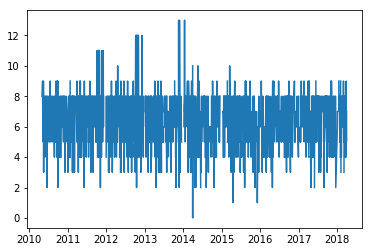

In [302]:
plt.plot(df.review_date,df.score)
plt.show()

In [303]:
df[df['score'] > 10]

,artist,link,review_date,review_type,score,title
917,Lee Bannon,https://www.youtube.com/watch?v=ZKU98ZjIwOU,2014-01-14,Album,13.0,Alternate/Endings
932,Sadsic,https://www.youtube.com/watch?v=OlB6Wvq3YtM,2013-11-27,Album,13.0,Self-Titled
939,Daniel Avery,https://www.youtube.com/watch?v=_g2wiO5w0dc,2013-11-19,Album,13.0,Drone Logic
1152,,https://www.youtube.com/watch?v=9F0z05m0oM0,2012-12-07,Album,12.0,We Don't Even Live Here
1178,,https://www.youtube.com/watch?v=QurcyHLpCEQ,2012-11-02,Album,12.0,Dripping
1181,The Bad,https://www.youtube.com/watch?v=hWxnq5EYbZU,2012-10-31,Album,12.0,Made Possible
1182,Mac,https://www.youtube.com/watch?v=2Ad2VVgVBnc,2012-10-30,Album,12.0,2
1183,Andy,https://www.youtube.com/watch?v=wA8kYFNE5IU,2012-10-29,Album,12.0,Luxury Problems
1184,Chelsea,https://www.youtube.com/watch?v=1Qy-Gs9hMq0,2012-10-26,Album,12.0,Unknown Rooms: A Collection of Acoustic Songs
1185,,https://www.youtube.com/watch?v=akZkPoJwEek,2012-10-26,EP,12.0,3rd EP EP REVIEW


In [258]:
soup = BeautifulSoup(requests.get('https://www.youtube.com/watch?v=tLWPSqE0DC4').content)

C:\Users\Jared\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\Jared\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [264]:
soup.prettify

<bound method Tag.prettify of <!DOCTYPE html>
<html data-cast-api-enabled="true" lang="en"><head><style name="www-roboto">@font-face{font-family:'Roboto';font-style:italic;font-weight:500;src:local('Roboto Medium Italic'),local('Roboto-MediumItalic'),url(//fonts.gstatic.com/s/roboto/v18/KFOjCnqEu92Fr1Mu51S7ACc6CsE.ttf)format('truetype');}@font-face{font-family:'Roboto';font-style:normal;font-weight:500;src:local('Roboto Medium'),local('Roboto-Medium'),url(//fonts.gstatic.com/s/roboto/v18/KFOlCnqEu92Fr1MmEU9fBBc9.ttf)format('truetype');}@font-face{font-family:'Roboto';font-style:normal;font-weight:400;src:local('Roboto Regular'),local('Roboto-Regular'),url(//fonts.gstatic.com/s/roboto/v18/KFOmCnqEu92Fr1Mu4mxP.ttf)format('truetype');}@font-face{font-family:'Roboto';font-style:italic;font-weight:400;src:local('Roboto Italic'),local('Roboto-Italic'),url(//fonts.gstatic.com/s/roboto/v18/KFOkCnqEu92Fr1Mu51xIIzc.ttf)format('truetype');}</style><script name="www-roboto">if (document.fonts && d

In [266]:
soup.find("strong", {"class": "watch-time-text"}).text

'Published on Mar 7, 2018'

In [94]:
r = requests.get("http://video.google.com/timedtext?lang=en&v=toQEov2nWas")

In [95]:
r.content

b''